In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
!pip install split-folders
import pandas as pd
import shutil
import os

# 파일 경로 설정
metadata_path = 'C:/Users/Denny/Downloads/iot_ewha/metadata.csv'
source_dir = 'C:/Users/Denny/Downloads/iot_ewha/faces_224'
base_dir = 'C:/Users/Denny/Downloads/iot_img/'  # 이 경로는 현재 작업 중인 주피터 노트북의 경로입니다.

## 아래 주석으로 처리한 코드는 faces_224가 들어있는 폴더 A에서 REAL이랑 FAKE로 폴더를 나누어놓은 base 폴더인 폴더 B로 이미지 데이터 복사하는 코드이므로 이미 복사해두었으면 굳이 안 돌리셔도 됩니다!

In [4]:
"""
import os
import shutil
import random

# 'train' 및 'val' 폴더 안에 'FAKE'와 'REAL' 서브폴더 생성
for subset in ['train', 'val', 'test']:
    for category in ['FAKE', 'REAL']:
        dir_path = os.path.join(base_dir, subset, category)
        os.makedirs(dir_path, exist_ok=True)
        
# 이미지 파일 가져오기
image_files = os.listdir(source_dir)
random.shuffle(image_files)

# 데이터 분할 및 복사
split_ratio = {'train': 0.7, 'val': 0.2, 'test': 0.1}
num_files = len(image_files)

start_idx = 0
for subset, ratio in split_ratio.items():
    end_idx = start_idx + int(num_files * ratio)
    subset_files = image_files[start_idx:end_idx]
    start_idx = end_idx
    
    for filename in subset_files:
        label = 'REAL' if filename.startswith('real') else 'FAKE'
        source_file = os.path.join(source_dir, filename)
        target_folder = os.path.join(base_dir, subset, label)
        shutil.copy(source_file, target_folder)

print("Data splitting and copying completed successfully!")

# metadata.csv 로드
metadata = pd.read_csv(metadata_path)

# 파일을 무작위로 선택하여 train, val, test로 분할
for _, row in metadata.iterrows():
    # 분할할 폴더 선택
    if row['videoname'][:2] == 'az':
        subset = 'train'
    elif row['videoname'][:2] == 'gk':
        subset = 'val'
    else:
        subset = 'test'
    
    # 대상 경로 설정
    target_folder = os.path.join(base_dir, subset, row['label'])
    os.makedirs(target_folder, exist_ok=True)
    
    # 소스 파일 경로
    source_file = os.path.join(source_dir, row['videoname'][:-4] + '.jpg')
    
    # 파일 복사
    shutil.copy(source_file, target_folder)
"""

'\nimport os\nimport shutil\nimport random\n\n# \'train\' 및 \'val\' 폴더 안에 \'FAKE\'와 \'REAL\' 서브폴더 생성\nfor subset in [\'train\', \'val\', \'test\']:\n    for category in [\'FAKE\', \'REAL\']:\n        dir_path = os.path.join(base_dir, subset, category)\n        os.makedirs(dir_path, exist_ok=True)\n        \n# 이미지 파일 가져오기\nimage_files = os.listdir(source_dir)\nrandom.shuffle(image_files)\n\n# 데이터 분할 및 복사\nsplit_ratio = {\'train\': 0.7, \'val\': 0.2, \'test\': 0.1}\nnum_files = len(image_files)\n\nstart_idx = 0\nfor subset, ratio in split_ratio.items():\n    end_idx = start_idx + int(num_files * ratio)\n    subset_files = image_files[start_idx:end_idx]\n    start_idx = end_idx\n    \n    for filename in subset_files:\n        label = \'REAL\' if filename.startswith(\'real\') else \'FAKE\'\n        source_file = os.path.join(source_dir, filename)\n        target_folder = os.path.join(base_dir, subset, label)\n        shutil.copy(source_file, target_folder)\n\nprint("Data splitting and cop

In [12]:
import keras
from keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 설정
train_data_generator = ImageDataGenerator(
    horizontal_flip = True, vertical_flip = True, zoom_range = 0.1,
    shear_range = 0.1, width_shift_range = 0.2, height_shift_range = 0.2, rotation_range = 90,
)
test_data_generator = ImageDataGenerator()

# 데이터 로딩
train_data = train_data_generator.flow_from_directory(os.path.join(base_dir, 'train'), target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=True)
test_data = test_data_generator.flow_from_directory(os.path.join(base_dir, 'test'), target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=True)
val_data = test_data_generator.flow_from_directory(os.path.join(base_dir, 'val'), target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=True)

# 클래스 레이블 확인
labels = train_data.class_indices
print(labels)

Found 60033 images belonging to 2 classes.
Found 26238 images belonging to 2 classes.
Found 19244 images belonging to 2 classes.
{'FAKE': 0, 'REAL': 1}


First we will split images to train/test data. And we don't want to apply augmentation to test data. Because of that we will manually split data and will give to ImageDataGenerator

### ImageDataGenerator does not really assign values to an array, it just hold pointers. Because of that every learning step CPU perform reading operations. This very slows learning speed. We will store data in numpy array type.

In [13]:
import numpy as np

def get_array_from_datagen(generator):
    x = []
    y = []
    generator.reset()
    for i in range(generator.__len__()):
        a, b = generator.next()
        x.append(a)
        y.append(b)
    x = np.concatenate(x, axis=0)  # 이미지 배열을 하나로 합칩니다.
    y = np.concatenate(y, axis=0)  # 레이블 배열을 하나로 합칩니다.
    print(x.shape)
    print(y.shape)
    return x, y

X_train, y_train = get_array_from_datagen(train_data)
X_test, y_test = get_array_from_datagen(test_data)

(60033, 128, 128, 3)
(60033,)
(26238, 128, 128, 3)
(26238,)


In [14]:
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
y_train = y_train.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

In [15]:
## 모델 돌리시려면 resampling 하셔야 해요!

import numpy as np

# `X_train`과 `y_train`의 샘플 수가 다름
print("Original X_train shape:", X_train.shape)  # (67014, 128, 128, 3)
print("Original y_train shape:", y_train.shape)  # (22338, 3)

# `y_train`의 샘플 수에 맞추기 위해 `X_train`에서 무작위로 샘플 선택
indices = np.random.choice(X_train.shape[0], y_train.shape[0], replace=False)
X_train_resampled = X_train[indices]    # `y_train`은 이미 목표 샘플 수에 맞춰져 있음

indices = np.random.choice(X_test.shape[0], y_test.shape[0], replace=False)
X_test_resampled = X_test[indices]

#print("Resampled X_train shape:", X_train_resampled.shape)
#print("y_train shape remains the same:", y_train.shape)
#print("Resampled X_test shape:", X_test_resampled.shape)
#print("y_test shape remains the same:", y_test.shape)

Original X_train shape: (60033, 128, 128, 3)
Original y_train shape: (20011, 3)


In [16]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

C:\Users\Denny\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [17]:
import gc
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl

input_shape = (128, 128, 3)
class_num = len(labels)

In [19]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)

In [22]:
# EfficientNetB5 모델 불러오기. B7까지 존재함.
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

258076736/258076736 [==============================] - 51s 0us/step


In [24]:
# EfficientNet이랑 쿵짝이 잘 맞는걸로 추정됨
def swish(x):
    return x * keras.backend.sigmoid(x)

def mish(x):
    return x * keras.backend.tanh(keras.backend.softplus(x))

In [26]:
import tensorflow as tf

class DropConnect(tf.keras.layers.Layer):
    def __init__(self, rate=0.5, **kwargs):
        super(DropConnect, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            binary_tensor = tf.keras.backend.random_binomial((tf.shape(inputs)[0], tf.shape(inputs)[1]), p=1-self.rate)
            return inputs * binary_tensor / (1 - self.rate)
        return inputs

In [31]:
# Sequential 모델 생성
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
    keras.layers.Dense(256, activation='swish'),  # 추가 Dense 레이어
    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
    keras.layers.Dense(256, activation='mish'),  # 추가 Dense 레이어
#    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
#    keras.layers.Dense(128, activation='swish'),  # 추가 Dense 레이어
    DropConnect(rate=0.5),  # DropConnect 레이어 추가
    keras.layers.Dense(256, activation='mish'),  # 추가 Dense 레이어
    DropConnect(rate=0.5),  # DropConnect 레이어 추가
    keras.layers.Dense(3, activation='softmax')  # 출력 레이어
])

In [35]:
# 선택된 인덱스로부터 데이터셋 다시 할당
X_resampled_train = X_train[:6000,:,:,:]
y_resampled_train = y_train[:6000,:]

X_resampled_test = X_test[:2000,:,:,:]
y_resampled_test = y_test[:2000,:]

Original X_train shape: (60033, 128, 128, 3)
Original y_train shape: (20011, 3)
Original X_test shape: (26238, 128, 128, 3)
Original y_test shape: (8746, 3)
Resampled X_train shape: (6000, 128, 128, 3)
Resampled y_train shape: (6000, 3)
Resampled X_test shape: (2000, 128, 128, 3)
Resampled y_test shape: (2000, 3)


In [ ]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # 다중 레이블 분류이므로 binary_crossentropy 사용
    metrics=['accuracy']
)

# 데이터 로딩 및 모델 학습
history = model.fit(
    X_resampled_train, y_resampled_train,
    validation_data=(X_resampled_test, y_resampled_test),
    batch_size =32,
    epochs=20,             # 일단은 epochs = 3으로 맞추고 돌려만 보자 제발 돌아가기만 해줘...
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/3
173/188 [==========================>...] - ETA: 1:03 - loss: 0.0225 - accuracy: 0.4814

In [ ]:
plot_history(history)

Best Model is EfficientNet, We will check recall, precision and f1-score values

In [28]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
# Sequential 모델 생성
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
    keras.layers.Dense(256, activation='swish'),  # 추가 Dense 레이어
    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
    keras.layers.Dense(256, activation='mish'),  # 추가 Dense 레이어
    keras.layers.Dropout(0.5),  # Dropout 레이어 추가
    keras.layers.Dense(128, activation='swish'),  # 추가 Dense 레이어
    DropConnect(rate=0.5),  # DropConnect 레이어 추가
    keras.layers.Dense(256, activation='mish'),  # 추가 Dense 레이어
    DropConnect(rate=0.5),  # DropConnect 레이어 추가
    keras.layers.Dense(3, activation='softmax')  # 출력 레이어
])

model.compile(
    optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)
model.fit(
    X_train_resampled, y_train,
    validation_data=(X_test_resampled, y_test),
    epochs=30,
    callbacks = [learning_rate_reduction],
    verbose = 1
)

Epoch 1/10
253/253 [==============================] - 38s 114ms/step - loss: 0.3191 - accuracy: 0.8698 - val_loss: 0.2177 - val_accuracy: 0.9511
Epoch 2/10
253/253 [==============================] - 27s 107ms/step - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.0803 - val_accuracy: 0.9811
Epoch 3/10
253/253 [==============================] - 27s 106ms/step - loss: 0.0530 - accuracy: 0.9834 - val_loss: 0.0717 - val_accuracy: 0.9767
Epoch 4/10
253/253 [==============================] - 27s 107ms/step - loss: 0.0430 - accuracy: 0.9891 - val_loss: 0.0939 - val_accuracy: 0.9711
Epoch 5/10
253/253 [==============================] - 27s 108ms/step - loss: 0.0465 - accuracy: 0.9820 - val_loss: 0.0791 - val_accuracy: 0.9900
Epoch 6/10
253/253 [==============================] - 27s 108ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0439 - val_accuracy: 0.9867
Epoch 7/10
253/253 [==============================] - 27s 108ms/step - loss: 0.0335 - accuracy: 0.9899 - val_loss: 0.1060 - val_ac

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis = 1), model.predict(X_test_resampled).argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       300
           1       0.99      0.99      0.99       300
           2       1.00      0.99      0.99       300

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



Okay let's look some predictions on validation dataset

In [30]:
import os
from shutil import copyfile
os.mkdir("./test_data")
os.mkdir("./test_data/REAL")
os.mkdir("./test_data/FAKE")

In [31]:
paths = []
names = []
k = 0

k = 0
path = "./val/REAL"
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("REAL")
    copyfile(path + "/" + i, f"test_data/REAL/{i}")
    k += 1
    if k == 8:
        break
        
path = "./val/FAKE"
k = 0
for i in os.listdir(path):
    paths.append(path + "/" + i)
    names.append("FAKE")
    copyfile(path + "/" + i,  f"test_data/FAKE/{i}")
    k += 1
    if k == 9:
        break

In [32]:
test_data_2 = test_data_generator.flow_from_directory("./test_data", target_size = (128,128), batch_size = 1, shuffle = False)

Found 25 images belonging to 3 classes.


In [33]:
print(labels)
labels_2 = {}
for k,v in labels.items():
    labels_2[v] = k
labels_2

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

In [34]:
predictions = model.predict(test_data_2).argmax(axis = 1)
pred_label = []
for i in predictions:
    pred_label.append(labels_2[i])
pred_label

['mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'mask_weared_incorrect',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask']

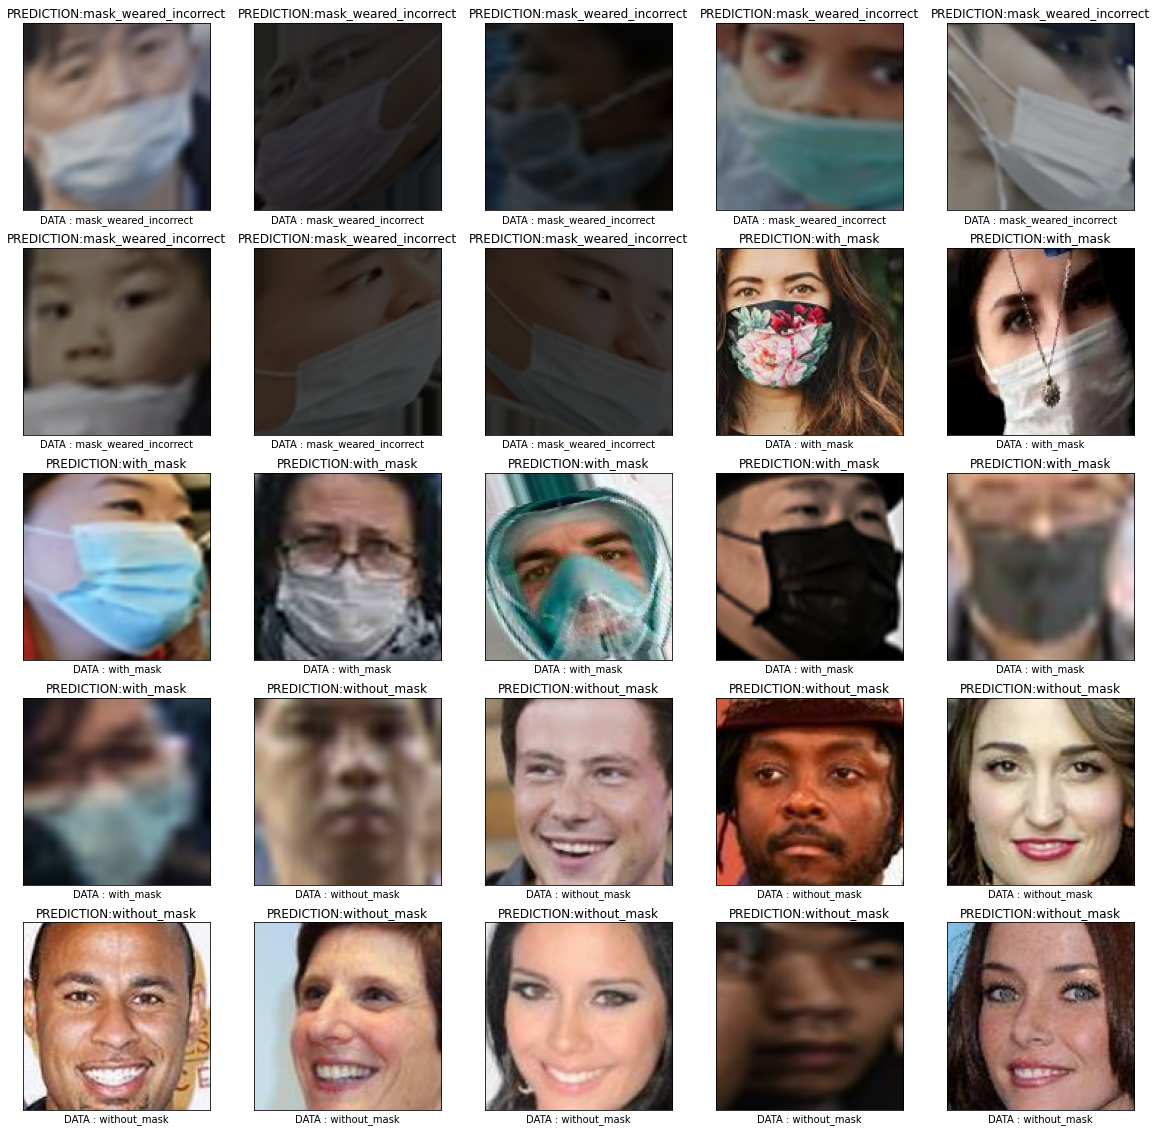

In [35]:
import os
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(paths[i]))
    ax.set_title(f"PREDICTION:{pred_label[i]}")
    ax.set_xlabel(f"DATA : {names[i]}")
#plt.tight_layout()
plt.show()